In [1]:
from os.path import exists
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag

platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())
cuda_output = !ldconfig -p|grep cudart.so|sed -e 's/.*\.\([0-9]*\)\.\([0-9]*\)$/cu\1\2/'
accelerator = cuda_output[0] if exists('/dev/nvidia0') else 'cpu'

!pip install torch_nightly -f https://download.pytorch.org/whl/nightly/{accelerator}/torch_nightly.html
!pip install fastai

import torch

print(torch.__version__)
print(torch.cuda.is_available())
print(torch.backends.cudnn.enabled)

Looking in links: https://download.pytorch.org/whl/nightly/cu92/torch_nightly.html
    100% |████████████████████████████████| 582.7MB 24kB/s 
tcmalloc: large alloc 1073750016 bytes == 0x60f84000 @  0x7feb113102a4 0x594e17 0x626104 0x51190a 0x4f5277 0x510c78 0x5119bd 0x4f5277 0x4f3338 0x510fb0 0x5119bd 0x4f5277 0x4f3338 0x510fb0 0x5119bd 0x4f5277 0x4f3338 0x510fb0 0x5119bd 0x4f6070 0x510c78 0x5119bd 0x4f5277 0x4f3338 0x510fb0 0x5119bd 0x4f6070 0x4f3338 0x510fb0 0x5119bd 0x4f6070
    100% |████████████████████████████████| 122kB 5.5MB/s 
    100% |████████████████████████████████| 61kB 9.1MB/s 
torchvision-nightly 0.2.1 has requirement pillow>=4.1.1, but you'll have pillow 4.0.0 which is incompatible.
1.0.0.dev20181106
True
True


In [2]:
import fastai
print(fastai.__version__)
from fastai import *
from fastai.vision import *

1.0.20


In [8]:
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse
from google.colab import auth
auth.authenticate_user()
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

E: Package 'python-software-properties' has no installation candidate
Selecting previously unselected package libfuse2:amd64.
(Reading database ... 22280 files and directories currently installed.)
Preparing to unpack .../libfuse2_2.9.7-1ubuntu1_amd64.deb ...
Unpacking libfuse2:amd64 (2.9.7-1ubuntu1) ...
Selecting previously unselected package fuse.
Preparing to unpack .../fuse_2.9.7-1ubuntu1_amd64.deb ...
Unpacking fuse (2.9.7-1ubuntu1) ...
Selecting previously unselected package google-drive-ocamlfuse.
Preparing to unpack .../google-drive-ocamlfuse_0.7.0-0ubuntu1~ubuntu18.04.1_amd64.deb ...
Unpacking google-drive-ocamlfuse (0.7.0-0ubuntu1~ubuntu18.04.1) ...
Setting up libfuse2:amd64 (2.9.7-1ubuntu1) ...
Processing triggers for libc-bin (2.27-3ubuntu1) ...
Setting up fuse (2.9.7-1ubuntu1) ...
Setting up google-drive-ocamlfuse (0.7.0-0ubuntu1~ubuntu18.04.1) ...
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleus

In [0]:
# Mount your google drive to access files from it 
!mkdir -p drive
!google-drive-ocamlfuse drive

In [0]:
# The image folder that I am using for this tutorial is located in my google drive under 'app' folder
# So we need to change directory to the 'app' folder

import os
os.chdir("drive/app")

In [11]:
!ls

data.zip  Melanoma  Melanoma_detection_Fastai.ipynb  turi_us_class.zip


In [0]:


from fastai import *
from fastai.vision import *

In [0]:
path = 'Melanoma'

In [0]:
data = ImageDataBunch.from_folder(path, ds_tfms=get_transforms(),num_workers=0, size=224).normalize(imagenet_stats)

In [15]:
print('Train size:', len(data.train_ds))
print('Valid size:', len(data.valid_ds))

Train size: 917
Valid size: 480


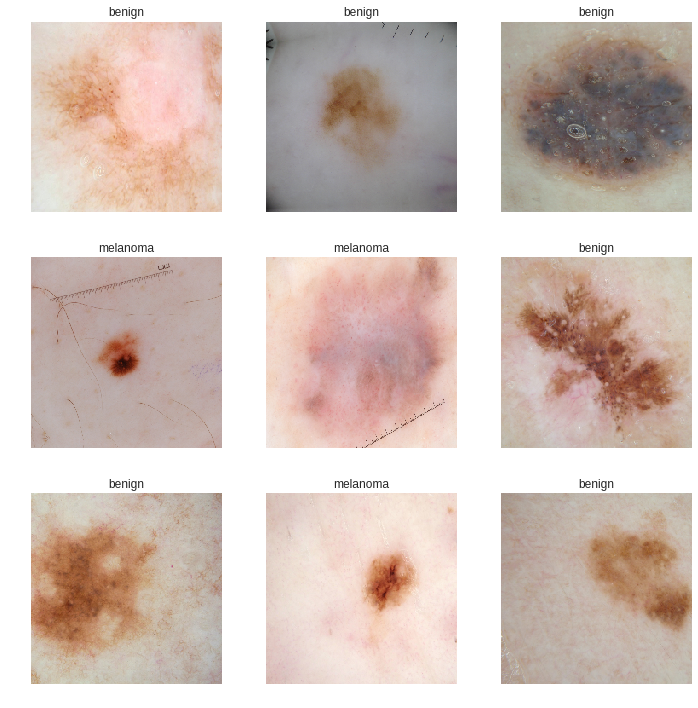

In [16]:
data.show_batch(rows=3, figsize=(10,10))

In [17]:
%%time
learn = create_cnn(data, models.resnet50, metrics=accuracy)
learn.fit(1)


Total time: 20:21
epoch  train_loss  valid_loss  accuracy
1      0.834818    1.048996    0.616667  (20:21)

CPU times: user 3min 21s, sys: 46.6 s, total: 4min 8s
Wall time: 20min 34s


In [18]:
%%timeit
learn.unfreeze()
learn.fit_one_cycle(3, slice(1e-5,3e-4), pct_start=0.05)

Total time: 32:52
epoch  train_loss  valid_loss  accuracy
1      0.189783    0.225980    0.918750  (10:32)
2      0.162783    0.235727    0.912500  (11:26)
3      0.139040    0.232577    0.918750  (10:53)

1 loop, best of 3: 31min 8s per loop


In [0]:
interp = ClassificationInterpretation.from_learner(learn)

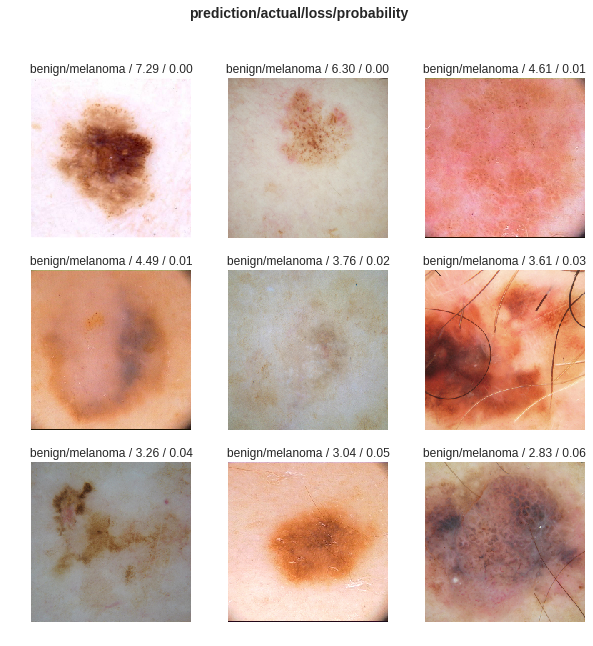

In [20]:
interp.plot_top_losses(9, figsize=(10,10))

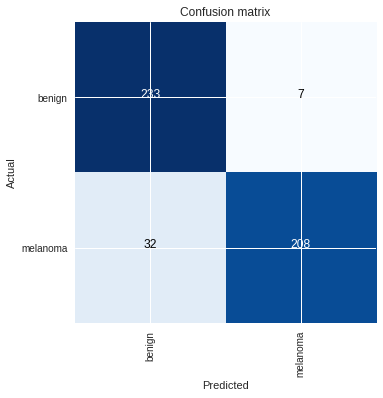

In [21]:
interp.plot_confusion_matrix()

In [0]:
learn.save('melanoma_Resnet50')

# **Testing the model using unseen images. **

In [0]:
img1 = open_image('benign.jpg')

In [0]:
img2 = open_image('melanoma.jpg')

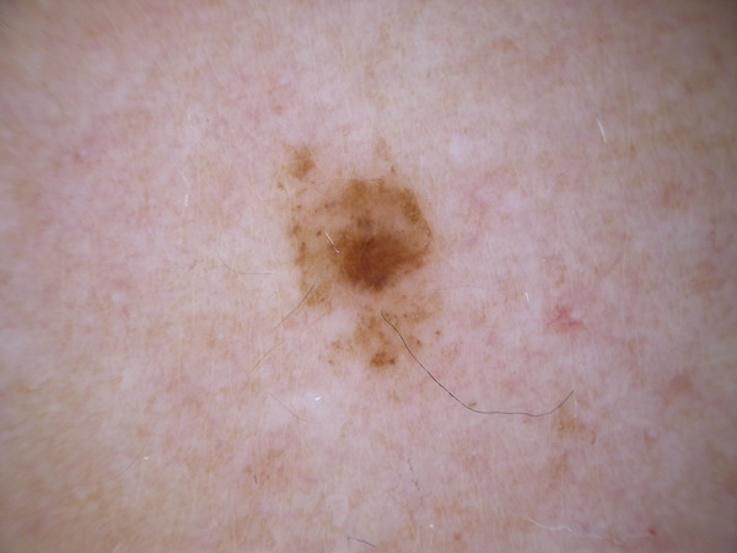

In [27]:
img1

In [28]:
pred_class,pred_idx,outputs = learn.predict(img1)
pred_class

'benign'

In [29]:
pred_class,pred_idx,outputs = learn.predict(img2)
pred_class

'melanoma'